## Maximizing Revenue for Taxi Cab Drivers through Payment Type Analysis

### Importing Libraries

In [364]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

### Loading the dataset

In [372]:
df = pd.read_csv('2020_Yellow_Taxi_Trip_Data.csv')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,01/01/2020 12:28:15 AM,01/01/2020 12:33:03 AM,1.0,1.2,1.0,N,238,239,1.0,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5
1,1.0,01/01/2020 12:35:39 AM,01/01/2020 12:43:04 AM,1.0,1.2,1.0,N,239,238,1.0,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5
2,1.0,01/01/2020 12:47:41 AM,01/01/2020 12:53:52 AM,1.0,0.6,1.0,N,238,238,1.0,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5
3,1.0,01/01/2020 12:55:23 AM,01/01/2020 01:00:14 AM,1.0,0.8,1.0,N,238,151,1.0,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0
4,2.0,01/01/2020 12:01:58 AM,01/01/2020 12:04:16 AM,1.0,0.0,1.0,N,193,193,2.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0


### Exploratory Data Analysis

In [293]:
df.shape

(355174, 18)

In [295]:
df.dtypes

VendorID                 float64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type             float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
dtype: object

##### Features that might affect the fare of the trip.

In [374]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])


In [376]:
df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['duration'] = df['duration'].dt.total_seconds()/60     # dividing by 60 gives the duration in mins
df['duration']

0          4.800000
1          7.416667
2          6.183333
3          4.850000
4          2.300000
            ...    
355169     3.233333
355170     5.483333
355171     5.733333
355172    13.483333
355173     8.500000
Name: duration, Length: 355174, dtype: float64

##### Extracting the necessary data from the dataframe

In [378]:
# Filtered data
df = df[['passenger_count', 'payment_type', 'fare_amount', 'trip_distance', 'duration']]
df

,passenger_count,payment_type,fare_amount,trip_distance,duration
0,1.0,1.0,6.0,1.20,4.800000
1,1.0,1.0,7.0,1.20,7.416667
2,1.0,1.0,6.0,0.60,6.183333
3,1.0,1.0,5.5,0.80,4.850000
4,1.0,2.0,3.5,0.00,2.300000
...,...,...,...,...,...
355169,2.0,1.0,4.0,0.41,3.233333
355170,2.0,1.0,5.5,0.84,5.483333
355171,0.0,1.0,6.0,0.70,5.733333
355172,0.0,1.0,12.5,3.20,13.483333


##### Finding missing values

In [380]:
df.isnull().sum()

passenger_count    660
payment_type       660
fare_amount          0
trip_distance        0
duration             0
dtype: int64

In [382]:
(660/len(df))*100

0.18582441282301068

In [384]:
df.dropna(inplace= True)
df

,passenger_count,payment_type,fare_amount,trip_distance,duration
0,1.0,1.0,6.0,1.20,4.800000
1,1.0,1.0,7.0,1.20,7.416667
2,1.0,1.0,6.0,0.60,6.183333
3,1.0,1.0,5.5,0.80,4.850000
4,1.0,2.0,3.5,0.00,2.300000
...,...,...,...,...,...
355169,2.0,1.0,4.0,0.41,3.233333
355170,2.0,1.0,5.5,0.84,5.483333
355171,0.0,1.0,6.0,0.70,5.733333
355172,0.0,1.0,12.5,3.20,13.483333


In [386]:
df['passenger_count'] = df['passenger_count'].astype('int64')
df['payment_type'] = df['payment_type'].astype('int64')

##### Checking duplicate values

In [388]:
df[df.duplicated()]

,passenger_count,payment_type,fare_amount,trip_distance,duration
2064,1,2,7.0,0.00,0.000000
2451,1,1,52.0,0.00,0.200000
2456,2,1,9.5,1.70,13.066667
2476,1,1,4.0,0.40,3.083333
3358,1,1,6.0,1.20,5.350000
...,...,...,...,...,...
355154,1,2,4.0,0.41,3.183333
355159,1,1,4.0,0.40,2.850000
355160,1,1,9.5,1.95,10.983333
355162,1,1,9.0,2.00,9.900000


##### Dropping duplicate values

In [390]:
df.drop_duplicates(inplace= True)

In [392]:
df.shape

(302820, 5)

##### Checking the contribution of passenger_count and payment_type in the dataset

In [317]:
df['passenger_count'].value_counts(normalize = True) # normalize will give the %, the contribution

passenger_count
1    0.627211
2    0.189882
3    0.059042
5    0.043376
4    0.036025
6    0.026521
0    0.017918
8    0.000017
9    0.000007
7    0.000003
Name: proportion, dtype: float64

In [319]:
df['payment_type'].value_counts(normalize = True)

payment_type
1    0.630708
2    0.358355
3    0.006753
4    0.004184
Name: proportion, dtype: float64

In [394]:
df = df[df['payment_type'] < 3]

In [396]:
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] < 6) ]

In [325]:
df.shape

(286220, 5)

##### Filtering categorical and numerical data

In [398]:
df['payment_type'].replace([1,2], ['Card', 'Cash'], inplace= True)
df

,passenger_count,payment_type,fare_amount,trip_distance,duration
0,1,Card,6.0,1.20,4.800000
1,1,Card,7.0,1.20,7.416667
2,1,Card,6.0,0.60,6.183333
3,1,Card,5.5,0.80,4.850000
4,1,Cash,3.5,0.00,2.300000
...,...,...,...,...,...
355166,1,Card,12.0,2.10,16.850000
355167,1,Card,8.0,1.73,8.050000
355168,3,Card,8.5,1.76,9.000000
355169,2,Card,4.0,0.41,3.233333


In [329]:
df.describe()

,passenger_count,fare_amount,trip_distance,duration
count,286220.000000,286220.000000,286220.000000,286220.000000
mean,1.618556,14.809752,3.752733,18.094647
std,1.064887,13.917085,4.557675,78.002258
min,1.000000,-110.000000,-0.880000,0.000000
25%,1.000000,7.000000,1.160000,6.833333
50%,1.000000,10.000000,2.050000,11.316667
75%,2.000000,16.500000,4.100000,17.933333
max,5.000000,491.000000,100.150000,1439.600000


In [402]:
df = df[df['fare_amount'] > 0]
df = df[df['trip_distance'] > 0]
df = df[df['duration'] > 0]

df.describe()

,passenger_count,fare_amount,trip_distance,duration
count,283491.000000,283491.000000,283491.000000,283491.000000
mean,1.619674,14.625015,3.785481,18.101593
std,1.065975,13.323338,4.562211,77.810240
min,1.000000,0.010000,0.010000,0.016667
25%,1.000000,7.000000,1.190000,6.916667
50%,1.000000,10.000000,2.080000,11.366667
75%,2.000000,16.500000,4.140000,17.933333
max,5.000000,400.000000,100.150000,1439.600000


##### Checking the outliers to find if we need to remove them.

(array([2.64567e+05, 1.83670e+04, 3.94000e+02, 9.80000e+01, 3.80000e+01,
        7.00000e+00, 8.00000e+00, 5.00000e+00, 4.00000e+00, 3.00000e+00]),
 array([1.00000e-02, 4.00090e+01, 8.00080e+01, 1.20007e+02, 1.60006e+02,
        2.00005e+02, 2.40004e+02, 2.80003e+02, 3.20002e+02, 3.60001e+02,
        4.00000e+02]),
 <BarContainer object of 10 artists>)

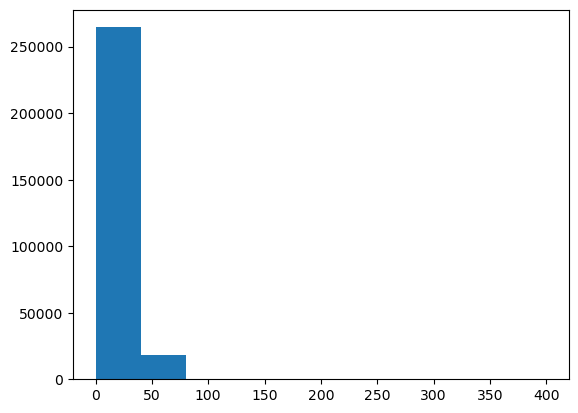

In [333]:
plt.hist(df['fare_amount'])

{'whiskers': [<matplotlib.lines.Line2D at 0x20386c77ad0>,
 'caps': [<matplotlib.lines.Line2D at 0x20386c77fe0>,
 'boxes': [<matplotlib.lines.Line2D at 0x20386c77860>],
 'medians': [<matplotlib.lines.Line2D at 0x20388249d30>],
 'fliers': [<matplotlib.lines.Line2D at 0x20386cb4350>],
 'means': []}

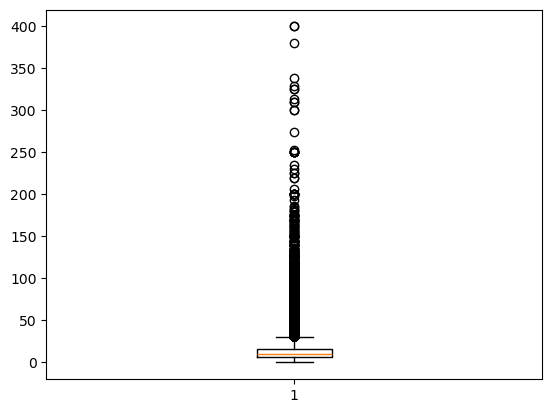

In [335]:
plt.boxplot(df['fare_amount'])

In [404]:
# inter-quantile range

for col in ['fare_amount', 'trip_distance', 'duration']:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    IQR = q3-q1

    lower_bound = q1-1.5 * IQR
    upper_bound = q3+1.5 * IQR

# Filtering the data on basis os lower_bound and upper_bound, the data should be between them.
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]


In [339]:
df

,passenger_count,payment_type,fare_amount,trip_distance,duration
0,1,Card,6.0,1.20,4.800000
1,1,Card,7.0,1.20,7.416667
2,1,Card,6.0,0.60,6.183333
3,1,Card,5.5,0.80,4.850000
5,1,Cash,2.5,0.03,0.883333
...,...,...,...,...,...
355166,1,Card,12.0,2.10,16.850000
355167,1,Card,8.0,1.73,8.050000
355168,3,Card,8.5,1.76,9.000000
355169,2,Card,4.0,0.41,3.233333


#### 1. Find if the customer prefer to pay with card or cash on the basis of trip distance and fare_amount. 

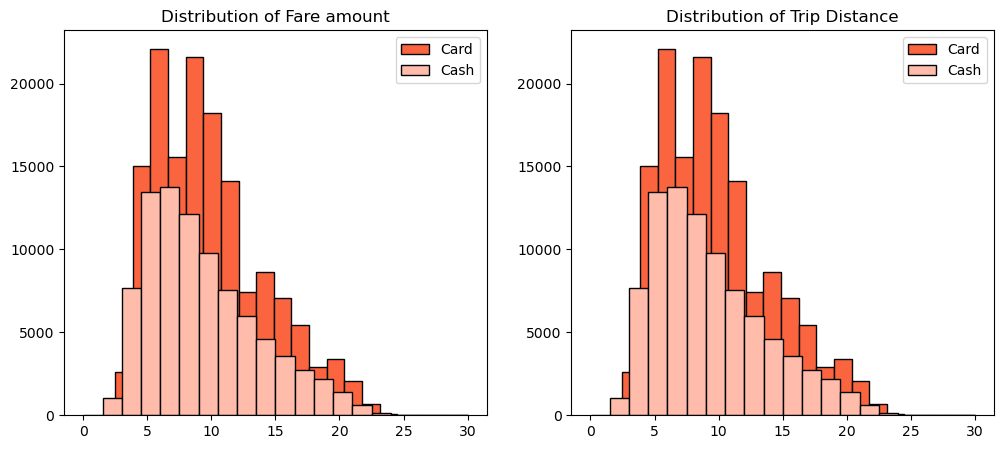

In [342]:
plt.figure(figsize= (12,5))
plt.subplot(1,2,1)
plt.title('Distribution of Fare amount')
plt.hist(df[df['payment_type'] == 'Card']['fare_amount'], histtype= 'barstacked', bins= 20, edgecolor = 'k', color = '#FA643F', label = 'Card')
plt.hist(df[df['payment_type'] == 'Cash']['fare_amount'], histtype= 'barstacked',  bins= 20, edgecolor = 'k', color = '#FFBCAB', label = 'Cash')
plt.legend()

plt.subplot(1,2,2)
plt.title('Distribution of Trip Distance')
plt.hist(df[df['payment_type'] == 'Card']['fare_amount'], histtype= 'barstacked', bins= 20, edgecolor = 'k', color = '#FA643F', label = 'Card')
plt.hist(df[df['payment_type'] == 'Cash']['fare_amount'], histtype= 'barstacked',  bins= 20, edgecolor = 'k', color = '#FFBCAB', label = 'Cash')
plt.legend()
plt.show()

##### Find the mean and standard deviation of fare amount and trip distance

In [406]:
df.groupby('payment_type').agg({'fare_amount':['mean', 'std'], 'trip_distance':['mean', 'std']})

fare_amount           trip_distance          
                    mean       std          mean       std
payment_type                                              
Card            9.844259  4.253694      2.148495  1.374259
Cash            9.561447  4.330578      2.028104  1.415177

### Prefernce of Payment Types
##### Find the % of customers who prefers to pay with card and cash.

In [346]:
df['payment_type']

0         Card
1         Card
2         Card
3         Card
5         Cash
          ... 
355166    Card
355167    Card
355168    Card
355169    Card
355170    Card
Name: payment_type, Length: 233683, dtype: object

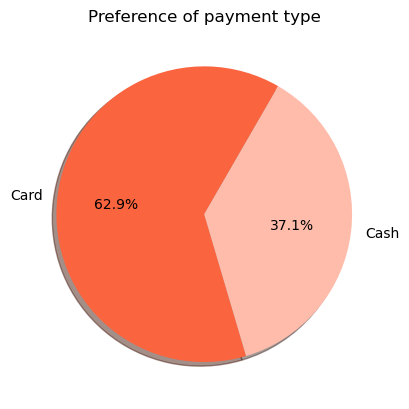

In [348]:

plt.title('Preference of payment type')
plt.pie(df['payment_type'].value_counts(normalize= True), labels= df['payment_type'].value_counts().index,
        startangle = 60, shadow= True, autopct= '%1.1f%%', colors= ['#FA643F', '#FFBCAB'])
plt.show()

- The proportion of customers paying with cards is significantly higher than those paying with cash, with card payments accounting for 62.9% of all transactions compared to cash payments at 37.1%.
- This indicated a strong preference among customers for suing card payments using cash, potentially due to convenience, security or incentives offered to card transactions.

### Analysis of payment type preference on the basis of Passesnger_count

##### Find the distribution of card and cash

In [408]:
passenger_count = df.groupby(['payment_type', 'passenger_count'])[['passenger_count']].count()
passenger_count

passenger_count
payment_type passenger_count                 
Card         1                          97087
             2                          29338
             3                           8822
             4                           4577
             5                           7165
Cash         1                          55853
             2                          16961
             3                           5788
             4                           4153
             5                           3939

In [410]:
passenger_count.rename(columns= {'passenger_count': 'count'}, inplace = True)
passenger_count.reset_index(inplace= True)

In [412]:
passenger_count['perc']= (passenger_count['count']/passenger_count['count'].sum())*100
passenger_count

,payment_type,passenger_count,count,perc
0,Card,1,97087,41.546454
1,Card,2,29338,12.554615
2,Card,3,8822,3.775200
3,Card,4,4577,1.958636
4,Card,5,7165,3.066119
5,Cash,1,55853,23.901182
6,Cash,2,16961,7.258123
7,Cash,3,5788,2.476860
8,Cash,4,4153,1.777194
9,Cash,5,3939,1.685617


In [414]:
df2 = pd.DataFrame(columns = ['payment_type', 1,2,3,4,5])
df2['payment_type'] = ['card', 'cash']
df2.iloc[0,1:] = passenger_count.iloc[0:5, -1]
df2.iloc[1,1:] = passenger_count.iloc[5:, -1]
df2

,payment_type,1,2,3,4,5
0,card,41.546454,12.554615,3.7752,1.958636,3.066119
1,cash,23.901182,7.258123,2.47686,1.777194,1.685617


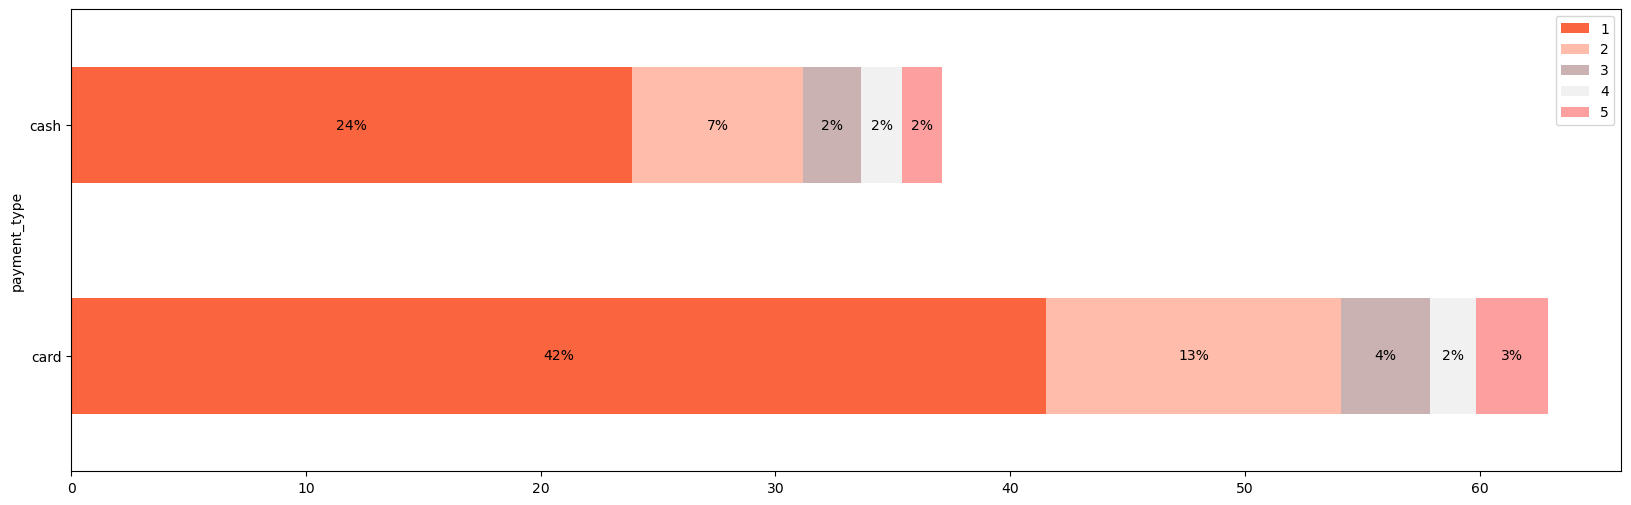

In [416]:
# create the plot
fig, ax = plt.subplots(figsize = (20,6))

# Plot the data
ax = df2.plot(x= 'payment_type', kind = 'barh', stacked= True, color = ['#FA643F', '#FFBCAB', '#CBB2B2', '#F1F1F1', '#FD9F9F'], ax = ax)

# Add percentage text
for p in ax.patches:
    width = p.get_width()     # Get bar width
    height = p.get_height()   # Get bar height
    x, y = p.get_xy()         # Get bottom-left coordinates
    
    ax.text(x + width /2,
            y + height/2,
            '{:.0f}%'.format(width),
            horizontalalignment = 'center',
            verticalalignment = 'center',
            fontsize=10, color='black')

plt.show()

- Among card payments, rides with a single passenger (passenger_count = 1) comprise the largest proportion, constituting 40.08% of all the card transactions.
- Similarly, cash payments are predominantly associated with single-passenger rides, making up 20.04% of all cash transactions.
- There is a noticeable decrease in the percentage of transactions as the passenger count increases, suggesting that larger group are less likely to use taxis or may opt for alternative payment methods.
- These insights emphasize the importance of considering both payment method and passenger count when analyzing transaction data, as they provide valuable insights into customer behavior and preferences.
  

##### The results generated can be proved using Hypothesis testing, that is most of the customers prefer to pay with card than cash. 

### Hypothesis Testing

#### Null hypotesis: There is no differencce in average fare between customers who use credit card and customers who use cash. 

#### Alternate hypothesis: There is a diff in avg fare between customers who use credit card and customers who use cash. 

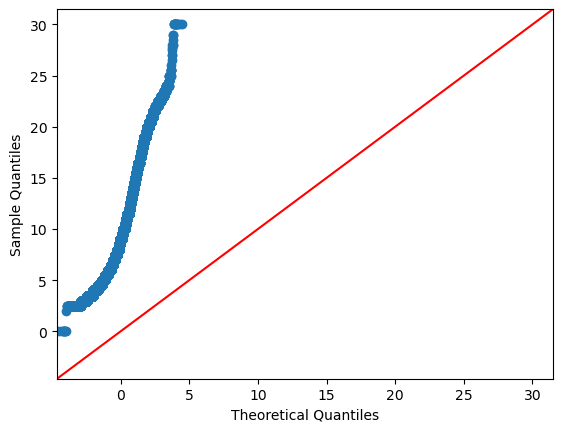

In [418]:
sm.qqplot(df['fare_amount'], line = '45')
plt.show()

In [368]:
print(df.columns)

Index(['payment_type', 1, 2, 3, 4, 5], dtype='object')


In [420]:
# Create the samples
card_sample = df[df['payment_type'] == 'Card']['fare_amount']
cash_sample = df[df['payment_type'] == 'Cash']['fare_amount']

In [422]:
t_stats, p_value = st.ttest_ind(a = card_sample, b= cash_sample, equal_var= False)
print('T-Statistics', t_stats, 'p-Value', p_value)

T-Statistics 15.350700238914365 p-Value 3.788278218118626e-53


In [424]:
3.788278218118626e-53 < 0.05

True

### Thus, we can clonclude that our Alernate Hypothesis is correct that there is a big difference in average fare of customers who pay with      credit card than thte customer who pay with cash.

With a T-statistic of 165.5 and p-value less than 0.05, we reject the null hypothesis, suggesting that there is indeed a significant difference in average fare between the two payment methods.